# Bayes Theorem and kNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

Load the glass dataset from the `datasets/glass.csv` file into a pandas DataFrame.

This is a short description of the columns in this dataset:

```plain
1. Id number: 1 to 214 (removed for convenience)
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
-- 1 building_windows_float_processed
-- 2 building_windows_non_float_processed
-- 3 vehicle_windows_float_processed
-- 4 vehicle_windows_non_float_processed (none in this database)
-- 5 containers
-- 6 tableware
-- 7 headlamps
```

you can read more about it [here](https://archive.ics.uci.edu/ml/datasets/Glass+Identification).
For convenience, I've pre-processed the original dataset and removed the ID attribute.

In [2]:
import pandas as pd 

df= pd.read_csv("datasets/glass.csv")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## Inspect the data

Use seaborn to plot a heatmap displaying the correlation matrix of every attribute in the dataset

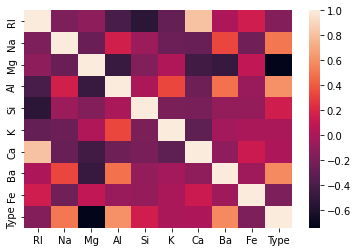

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt 
sns.heatmap(df.corr())
plt.show()


In the cell below, use pandas to get an idea of the distribution of the values in each variable

In [4]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


## Bayes Theorem

The point of this section is to consolidate some of the ideas explained in the past lectures regarding bayes theorem.

### 1) Prepare and inspect the dataset

The full dataset has 7 types of glass, but to make these concepts easier to visualize, let's reduce the dataset to 2 classes only.

Use pandas to create a filtered version of the dataset, where only types `1` and `7` are present

In [5]:
df_filtered = df.loc[(df['Type'] == 7) | (df['Type'] == 1)]
df_filtered.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Plot the heatmap and the stats from the preious section, but on the filtered dataset

            RI        Na        Mg        Al        Si         K        Ca  \
RI    1.000000  0.070756  0.390138 -0.584621 -0.728410 -0.234257  0.584969   
Na    0.070756  1.000000 -0.642001  0.472276 -0.286824 -0.534359  0.004782   
Mg    0.390138 -0.642001  1.000000 -0.821480 -0.422799  0.253823  0.057084   
Al   -0.584621  0.472276 -0.821480  1.000000  0.384408 -0.153047 -0.281534   
Si   -0.728410 -0.286824 -0.422799  0.384408  1.000000  0.211186 -0.288118   
K    -0.234257 -0.534359  0.253823 -0.153047  0.211186  1.000000 -0.520444   
Ca    0.584969  0.004782  0.057084 -0.281534 -0.288118 -0.520444  1.000000   
Ba   -0.217240  0.656019 -0.749993  0.585325  0.110545 -0.136821 -0.388852   
Fe   -0.062835 -0.343512  0.186073 -0.142168  0.089361  0.059827  0.089544   
Type -0.298934  0.701920 -0.908954  0.799578  0.222939 -0.138379 -0.193491   

            Ba        Fe      Type  
RI   -0.217240 -0.062835 -0.298934  
Na    0.656019 -0.343512  0.701920  
Mg   -0.749993  0.186073 -0.90

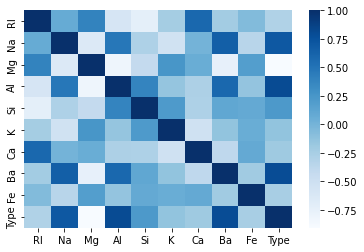

In [6]:
print(df_filtered.corr())
sns.heatmap(df_filtered.corr(), cmap="Blues")
plt.show()

In [7]:
df_filtered.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1.518249,13.593737,2.669495,1.444747,72.720707,0.411616,8.707677,0.313636,0.044242,2.757576
std,0.002451,0.781867,1.516844,0.548568,0.711392,0.404126,0.723177,0.593496,0.078974,2.744534
min,1.511310,11.950000,0.000000,0.290000,70.260000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516980,12.930000,2.015000,1.165000,72.270000,0.080000,8.430000,0.000000,0.000000,1.000000
50%,1.517640,13.440000,3.480000,1.290000,72.950000,0.540000,8.670000,0.000000,0.000000,1.000000
75%,1.519100,14.205000,3.605000,1.795000,73.110000,0.590000,9.035000,0.535000,0.070000,7.000000
max,1.526670,15.790000,4.490000,2.880000,75.180000,2.700000,10.170000,2.880000,0.310000,7.000000


Filter the dataset even further, by removing all attributes except the `Type`, and the **top 3 attributes that positively correlate with `Type`**.

Then, use seaborn to plot the relations between these attributes and the `Type`

**NOTE:** my plot removes the names of the variables to avoid giving away the solution, your plot should have the names of the variables

In [8]:
# df[['Type','Al','Ba','Mg']]
df_final = df_filtered[['Type','Al','Ba','Mg']]

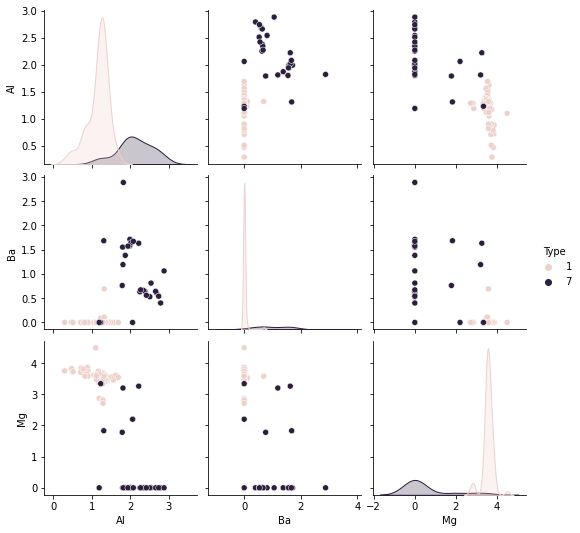

In [9]:
import matplotlib.pyplot as plt
plot = sns.pairplot(data=df_final, hue="Type")

In [10]:
# your code here

Finally, use scikit-learn to split the dataset into training and testing, using 25% of the datapoints for testing. 

To get the same values as I do, set `random_state=0`

In [11]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df_final,random_state = 0, test_size=0.25)

train[train['Type']==1].shape[0]/train.shape[0]


0.7162162162162162

### 2) Model 1: prior only

Use numpy to make a `prior` model (a function) that predicts the label (`Type`) based solely on the prior information (from the training set).

Calculate the accuracy of the prediction (in the testing set)

In [12]:
def calculate_prior(data, label, column='Type'):
    r"""Calculates the prior probability of `label` within `data`
    
    Parameters
    ----------
    label : int
        value of the label for which the prior will be calculated
    column : str
        the name of the column to be considered as the label in `data`, 
        'Type' by default
    data : pandas DataFrame
        the data
    
    Returns
    -------
    float
        P(label)
    """
    r""" 
    Por exemplo, 
    train[train[Types]==1].shape[0] -> quantidade total de tipos 1
    train.shape[0] -> Número total de dados
    """
    return data[data[column] == label].shape[0] / data.shape[0]

In [13]:
def prior_model(a, b, label_a, label_b, data):
    r"""Predicts binary labels based on the prior probability
    
    Parameters
    ----------
    a : float 
        Prior probability of label a
    b : float
        Prior probability of label b
    label_a : int
        value of label a
    label_b : int
        value of label b
    data : pandas DataFrame
        the data for which predictions will be made
    
    Returns
    -------
    numpy.array
        An array of predicitons for every from the set {label_a, label_b}
        
    Notes
    -----
    HINT: remember to reset the random seed for reproducible results
    Esta função retorna uma lista um série de valores "a" ou "b".
    Nesta lista, a probabilidade de escolher o item "a" é "a", ou seja,
    a probabilidade de escolher "a" na lista é a mesma probabilidade de 
    escolher "a" na data_set.
    Além dos mais, a lista possui o mesmo número de itens da coluna type
    do dataset.
    """
    np.random.seed(0)
    """
    Explicando a função:
    [label_a, label_b] -> Define que o array só poussuirá ou o valor label_a ou o valor label_b.
    p=[a,b] -> "a" e "b" São as probabilidades de um item na lista ser "label_a" e "label_b".
    size=data.shape[0] -> A extensão da lista
    """
    return np.random.choice([label_a, label_b], p=[a,b], size=data.shape[0])
    

In [14]:
prior_type_1 = calculate_prior(train, 1)
priot_type_7 = calculate_prior(train, 7)

pred = prior_model(prior_type_1, priot_type_7, 1, 7, test)
print(pred)

[1 1 1 1 1 1 1 7 7 1 7 1 1 7 1 1 1 7 7 7 7 7 1 7 1]


In [15]:
from sklearn.metrics import accuracy_score
#COMO FUNCIONA A FUNÇÂO ACCURACY_PRIOR
#ELA CONTA O NÚMERO DE CASOS QUE FORAM PREVISTOS CORRETAMENTE
#E DIVIDE PELO TOTAL DE CASOS
count = 0
for i in range(len(pred)):
    count += pred[i]== np.array(test["Type"])[i]
print(count/len(pred))

accuracy_prior = accuracy_score(test["Type"], pred)
print(accuracy_prior)

0.44
0.44


### Model 2: naive bayes

You probably agree that the model we just implemented is not very good (after all, we did not even rely on the features of the data).
Now, we will build a model called [Naive Bayes](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) from scratch.

We are looking to calculate the conditional probability that `Type` is 1 (or 7) given the 3 attributes we selected above, this is: 

$$P(T=1 | x_1, x_2, x_3)$$

where $T$ represents the `type` and $x_1, x_2, x_3$ is a vector of features $\mathbb{x}$

To build this classifier, we are going to use the [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Translating what we want to estimate to our problem, we can that Bayes' theorem for type 1 is written as follows:

$$P(T=1|\mathbb{x}) = \frac{P(\mathbb{x}|T=1)P(T=1)}{P(\mathbb{x})}$$

and for type 7

$$P(T=7|\mathbb{x}) = \frac{P(\mathbb{x}|T=7)P(T=7)}{P(\mathbb{x})}$$

To build a Bayes' classifier using this, we will estimate the likelihood under the assumption that variables $x_1, x_2, $ and $x_3$ are independently and identically distributed, which allows us to model the likelihood as:

$$P(x_1, x_2, x_3 | T=t) = P(x_1 | T=t)P(x_2 | T=t)P(x_3 | T=t)$$

Finally, the decision rule will be implemented as selecting the class that results in the highest posterior.

Implement the classes below using the training set, and calculate the accuracy in the testing set.

**NOTE:** For implementing `conditional_prob`, you will need to fit a normal distribution to a univariate data, please [read the documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) of the function that will help you implement this (if you don't have scipy installed, you can install it running `pip install scipy` on your console). Once you fit the distribution to the data, you can then call the `pdf` method of the distribution to calculate the probability of a single value.

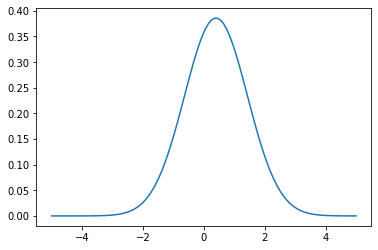

In [16]:
from scipy.stats import norm
import seaborn as sns

def calculate_prior(data, label, column='Type'):
    r"""Calculates the prior probability of `label` within `data`
    
    Parameters
    ----------
    label : int
        value of the label for which the prior will be calculated
    column : str
        the name of the column to be considered as the label in `data`, 
        'Type' by default
    data : pandas DataFrame
        the data
    
    Returns
    -------
    float
        P(label)
    """
    r""" 
    Por exemplo, 
    train[train[Types]==1].shape[0] -> quantidade total de tipos 1
    train.shape[0] -> Número total de dados
    """
    return data[data[column] == label].shape[0] / data.shape[0]



def conditional_prob(data, material, tipo_de_vidro, coluna_com_tipo_de_vidro='Type'):
    """(data, column, label, label_column='Type')"""
    r"""Calculates the conditional probability P(column|label)
    
    Parameters
    ----------
    data : pandas DataFrame
        the data to be fitted
    column : str
        the name of the column in `data` corresponding to the variable
    label : int
        the value of the label for the conditional probability
    label_column : the name of the column in `data`, defaults to 'Type'
    
    Returns
    -------
        a scipy normal continuous random variable fitted to the conditional probability
    Notes
    -----
    HINT: remember that the parameters of the normal distribution are the mean and the standard deviation
    """
    mu = data[data[coluna_com_tipo_de_vidro] == tipo_de_vidro][material].mean()
    sigma = data[data[coluna_com_tipo_de_vidro] == tipo_de_vidro][material].std()
    #Retornaa uma função de distribuição de um material em um dado tipo de vidro
    #O eixo x é a quantidade de um dado material
#     print(mu)
    return norm(mu,sigma)
    
x = np.linspace(-5,5,100)
func = conditional_prob(train, "Mg", 7).pdf(x)
plt.plot(x, func)
conditional_prob(train, "Mg", 1)

Use your implementation to calculate the posterior probability of a label given the data

In [17]:
def posterior_probability(data, cond_probs, prior):
    r"""Calculates the posterior probability of the label using the priors and conditional probabilities provided
    using the naive bayes assumption
    
    Parameters
    ----------
    data : pandas.DataFrame
        a dataframe containing samples for which the posterior probability will be calculated
    cond_probs : dict
        a python dictionary with a key for every variable in `data` and the
        corresponding conditional probability as the value
    prior : float
        posterior probability of a label
    
    Returns
    -------
    numpy.array
        an array with the posterior probabilities of each sample in `data`
    """
    def inner_multiplication(row):
        # we start with the prior
        mult = prior
        # we iterate every variable, and multiply the conditional probability to the prior
        
        for column, distribution in cond_probs.items():
            mult *= distribution.pdf(row[column])
            #print(f"column:{column}, distribution:{distribution}")
        return mult
    
    cols = list(cond_probs.keys())
    
    #    MINHA VERSAO DA FUNCAO
############################################################    
    probabilites = list()
    for linha in data[cols].values:
        multiplicador = prior
        for num, item in enumerate(linha):
            multiplicador *= cond_probs[cols[num]].pdf(item)
        probabilites.append(multiplicador*prior)
    probabilites= np.array(probabilites)
###########################################################

    return data[cols].apply(inner_multiplication, axis=1).values * prior
  

probabilidades_condicionais = {
    "Al":conditional_prob(train, "Al", 1),
    "Ba":conditional_prob(train, "Ba", 1),
    "Mg":conditional_prob(train, "Mg", 1)
}

prior = calculate_prior(train, 1)

posterior_probability(train, probabilidades_condicionais, prior)


array([1.77661176e+000, 5.60684663e+000, 1.73424198e-133, 1.65535664e-080,
       3.65147664e-080, 5.50091785e+000, 1.89319123e-081, 2.15530177e-080,
       3.99732329e+000, 2.33606916e+000, 4.01735341e+000, 4.28198173e+000,
       4.82881781e+000, 1.39380940e+000, 5.39248067e-081, 4.21734862e+000,
       1.10391433e-010, 2.92134990e+000, 4.01996466e+000, 5.21722022e+000,
       5.25666896e+000, 1.63307411e+000, 5.17917848e+000, 1.98957177e-001,
       1.43184632e+000, 2.28389812e-123, 5.15501487e+000, 2.69636398e-004,
       4.35605180e+000, 3.27506502e+000, 4.25910153e-001, 4.73669159e+000,
       4.43640300e+000, 4.33543576e+000, 1.23653106e-002, 1.66271712e+000,
       5.19214081e+000, 3.45242182e+000, 4.35267566e+000, 1.65066264e-125,
       4.33339749e-079, 3.60134067e+000, 4.20457925e-078, 4.74628352e+000,
       3.25556453e-136, 9.24401358e-001, 4.53227348e+000, 2.80872918e+000,
       6.68613807e-131, 2.43242996e-125, 3.06524092e+000, 2.70073838e+000,
       4.23327639e-080, 2

below, I provide the code that uses the functions you just implemented to predict using the naive classifier 

In [18]:
def naive_classifier(data, cond_probs, priors):
    r"""Classifies samples in `data` using the naive bayes assumption
    
    Parameters
    ----------
    data : pandas.DataFrame
        a dataframe containing samples for which predictions will be made
    cond_probs : dict of dicts
        a python dictionary with a key for every label in `priors`
        and a dictionary compatible with `posterior_probability` as the value
    priors : dict
        a python dictionary with a key for every label in `data` and the
        corresponding prior as the value
    
    Returns
    -------
    numpy.array
        An array of predicitons for every from the set of labels corresponding to keys in `priors`
    """
    predictions = {}
    for tipo_de_vidro, prior in priors.items():
        predictions[tipo_de_vidro] = posterior_probability(data, cond_probs[tipo_de_vidro], prior)
    # return predictions by indicating the label with maximum posterior
    print(pd.DataFrame(predictions).idxmax(axis=1))
    print(pd.DataFrame(predictions))
    return pd.DataFrame(predictions).idxmax(axis=1).values

**OPTIONAL:** you can use the code below to run all the pipeline, assuming you input the names of your training and testing datasets correctly

In [19]:
# training
# build a dictionary of priors for each class
priors = {
    1: calculate_prior(train, 1),
    7: calculate_prior(train, 7)
}

# build a dictionary of posteriors for each class
attributes = [c for c in train.columns if c != 'Type']
cond_probs = {}
cond_probs[1] = {col: conditional_prob(train, col, 1) for col in attributes}
cond_probs[7] = {col: conditional_prob(train, col, 7) for col in attributes}
# print(cond_probs)
# testing
# predict
pred = naive_classifier(test, cond_probs, priors)
print(pred)
# evaluate
accuracy = accuracy_score(test['Type'], pred)
print(accuracy)

0     1
1     7
2     1
3     1
4     7
5     7
6     1
7     7
8     1
9     7
10    1
11    7
12    7
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    1
23    7
24    1
dtype: int64
                1             7
0    3.233324e+00  9.645217e-06
1    4.038650e-67  2.651031e-04
2    2.164245e+00  1.291213e-05
3    5.188985e-04  3.914832e-05
4    5.324107e-31  5.252363e-03
5   1.333738e-260  3.512129e-05
6    5.114912e+00  1.635714e-06
7    3.856798e-12  8.511769e-04
8    3.760591e-03  3.139819e-05
9   2.082446e-100  5.099956e-03
10   6.611799e-03  2.794739e-05
11  4.565565e-112  1.178825e-02
12  4.608836e-127  9.889399e-03
13   5.068716e+00  4.043173e-06
14   5.311688e+00  1.034284e-06
15   4.815469e+00  4.675322e-06
16   4.847049e+00  3.726725e-06
17   5.189418e+00  2.566799e-06
18   3.448852e+00  8.739354e-06
19   4.122952e+00  6.067910e-06
20   8.861112e-01  5.003388e-08
21   1.483520e+00  1.550798e-07
22   4.284637e+00  3.011917e-06
23   1.492148e-64  

# kNN

Split the unfiltered dataset on training and testing (25% for testing), and use scikit-learn to fit a k nearest neighbors classifier, 

Make a plot that shows the test accuracy of the classifier on the y axis, and values of k on the x axis, use k from 2 to 15.

**Suggestion:** extract the data and the labels into numpy arrays before starting this excersice, to follow more closely scikit-learn conventions

C:\Users\Luiz Luz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Luiz Luz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Luiz Luz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Luiz Luz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\Luiz Luz\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have val

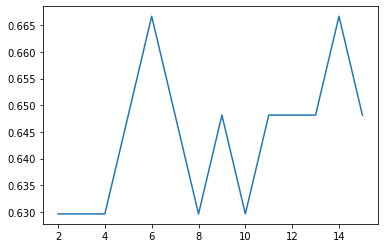

In [20]:
from sklearn.neighbors import KNeighborsClassifier
X = df.drop("Type", axis=1)
y = df["Type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

metrics = {"k":[], "score":[]}

for i in range(2,16):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train)
    metrics['k'].append(i)
    metrics['score'].append(accuracy_score (neigh.predict(X_test), y_test))

plt.plot(metrics['k'], metrics['score']) 

# Optional, further explorations

read the documentation on kNN classifiers on scikit-learn, and play with the other parameters to determine if other versions of kNN improve the results.